In [1]:
%pip install matplotlib networkx py2neo

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ----- ---------------------------------- 1.0/8.1 MB 6.3 MB/s eta 0:00:02
   --------- ------------------------------ 1.8/8.1 MB 4.2 MB/s eta 0:00:02
   ----------- ---------------------------- 2.4/8.1 MB 3.9 MB/s eta 0:00:02
   --------------- ------------------------ 3.1/8.1 MB 3.8 MB/s eta 0:00:02
   ------------------ --------------------- 3.7/8.1 MB 3.5 MB/s eta 0:00:02
   ------------------ --------------------- 3.7/8.1 MB 3.5 MB/s eta 0:00:02
   ------------------- -------------------- 3.9/8.1 MB 2.7 MB/s eta 0:00:02
   ---------------------- ----------------- 4.5/8.1 MB 2.7 MB/s eta 0:00:02
   ------------------------ --------------- 5.0/8.1 MB 2.6 MB/s eta 0:00:02
   --------------------------- ------------ 5.5/8.1 MB 2.7 MB/s eta 0:00:01
   ------------------------------- ------

In [2]:
from langchain_neo4j import Neo4jGraph
from dotenv import load_dotenv
import os
import networkx as nx
import matplotlib.pyplot as plt
from py2neo import Graph as Py2NeoGraph

# Load environment variables
load_dotenv(override=True)

NEO4J_URI = os.getenv("NEO4J_URI")
NEO4J_USERNAME = os.getenv("NEO4J_USERNAME")
NEO4J_PASSWORD = os.getenv("NEO4J_PASSWORD")

# Connect to Neo4j using LangChain
try:
    graph = Neo4jGraph(
        url=NEO4J_URI,
        username=NEO4J_USERNAME,
        password=NEO4J_PASSWORD,
    )
    
    # Test the connection
    result = graph.query("MATCH (n) RETURN count(n) AS count")
    print(f"Connected to Neo4j. Current node count: {result[0]['count']}")
except Exception as e:
    print(f"Error connecting to Neo4j: {e}")


Connected to Neo4j. Current node count: 55


In [3]:
def create_sample_knowledge_graph():
    """Create a sample knowledge graph with various node types and relationships"""
    
    # Clear existing data (optional - comment out if you want to preserve existing data)
    print("Clearing existing data...")
    graph.query("MATCH (n) DETACH DELETE n")
    
    # Create nodes and relationships for a sample academic knowledge graph
    create_query = """
    // Create Person nodes (researchers)
    CREATE (alice:Person {name: 'Alice Smith', title: 'Professor', field: 'Computer Science'})
    CREATE (bob:Person {name: 'Bob Johnson', title: 'Associate Professor', field: 'Data Science'})
    CREATE (charlie:Person {name: 'Charlie Brown', title: 'PhD Student', field: 'Machine Learning'})
    
    // Create Paper nodes
    CREATE (paper1:Paper {title: 'Introduction to Knowledge Graphs', year: 2020, citations: 45})
    CREATE (paper2:Paper {title: 'Neo4j and Graph Databases', year: 2021, citations: 32})
    CREATE (paper3:Paper {title: 'Machine Learning on Graphs', year: 2022, citations: 18})
    
    // Create Topic nodes
    CREATE (kg:Topic {name: 'Knowledge Graphs'})
    CREATE (ml:Topic {name: 'Machine Learning'})
    CREATE (gdb:Topic {name: 'Graph Databases'})
    
    // Create Institution node
    CREATE (uni:Institution {name: 'Tech University', location: 'San Francisco'})
    
    // Create relationships
    CREATE (alice)-[:AUTHORED]->(paper1)
    CREATE (alice)-[:AUTHORED]->(paper2)
    CREATE (bob)-[:AUTHORED]->(paper2)
    CREATE (charlie)-[:AUTHORED]->(paper3)
    CREATE (bob)-[:AUTHORED]->(paper3)
    
    CREATE (alice)-[:WORKS_AT]->(uni)
    CREATE (bob)-[:WORKS_AT]->(uni)
    CREATE (charlie)-[:STUDIES_AT]->(uni)
    
    CREATE (alice)-[:MENTORS]->(charlie)
    CREATE (bob)-[:MENTORS]->(charlie)
    
    CREATE (paper1)-[:ABOUT]->(kg)
    CREATE (paper2)-[:ABOUT]->(gdb)
    CREATE (paper2)-[:ABOUT]->(kg)
    CREATE (paper3)-[:ABOUT]->(ml)
    CREATE (paper3)-[:ABOUT]->(gdb)
    
    CREATE (alice)-[:RESEARCHES]->(kg)
    CREATE (alice)-[:RESEARCHES]->(gdb)
    CREATE (bob)-[:RESEARCHES]->(ml)
    CREATE (bob)-[:RESEARCHES]->(gdb)
    CREATE (charlie)-[:RESEARCHES]->(ml)
    """
    
    graph.query(create_query)
    
    # Verify creation
    result = graph.query("MATCH (n) RETURN count(n) AS count")
    print(f"Created {result[0]['count']} nodes")
    
    # Count relationships
    rel_result = graph.query("MATCH ()-[r]->() RETURN count(r) AS count")
    print(f"Created {rel_result[0]['count']} relationships")

# Create the sample knowledge graph
create_sample_knowledge_graph()


Clearing existing data...
Created 10 nodes
Created 20 relationships


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated function: `id`.} {position: line: 3, column: 12, offset: 26} for query: '\n    MATCH (n)\n    RETURN id(n) AS id, labels(n) AS labels, properties(n) AS properties\n    '
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated function: `id`.} {position: line: 3, column: 12, offset: 35} for query: '\n    MATCH (a)-[r]->(b)\n    RETURN id(a) AS source, id(b) AS target, type(r) AS type\n    '
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning

NetworkX graph created with 10 nodes and 20 edges


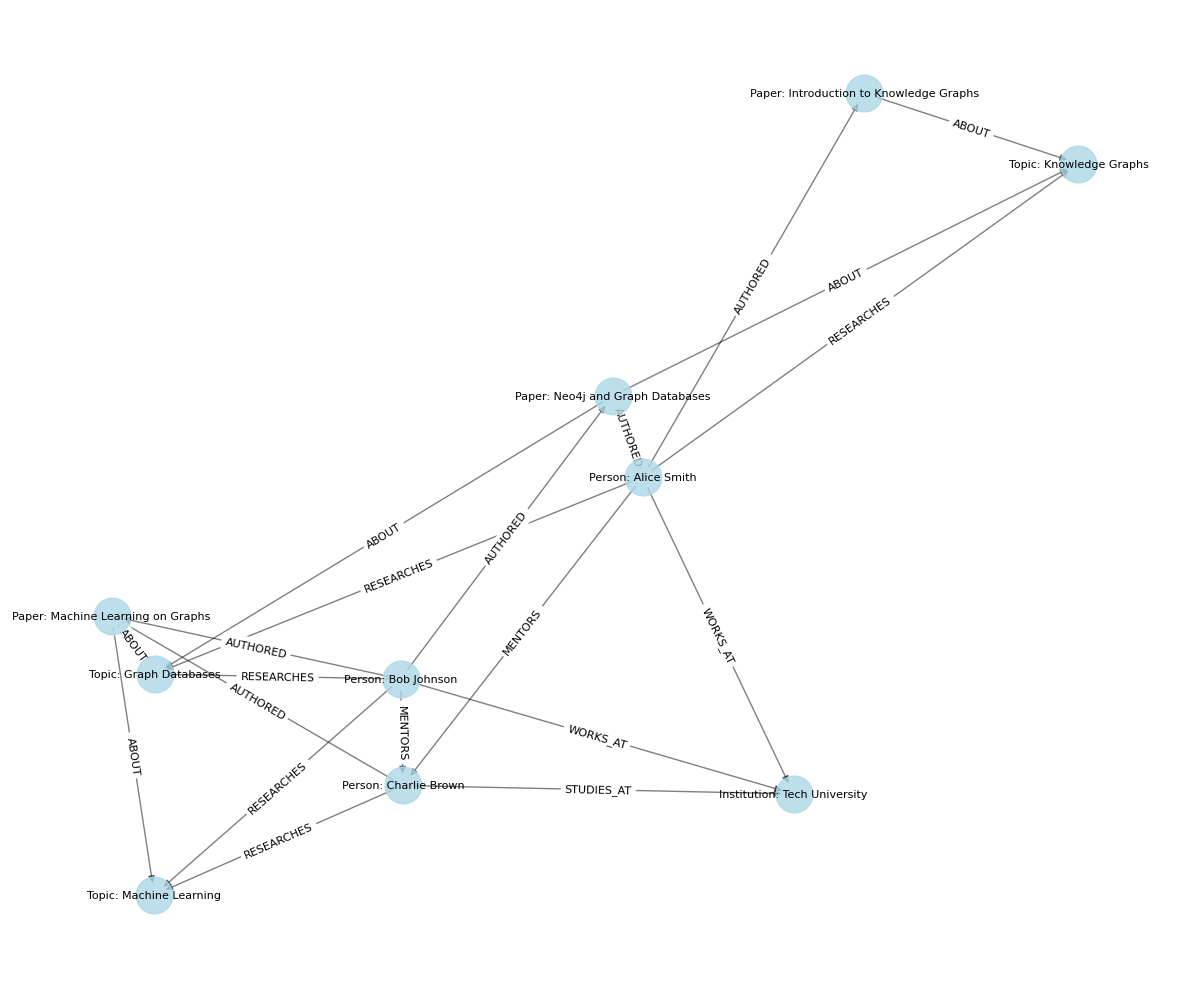

In [4]:
def query_knowledge_graph(cypher_query):
    """Execute a Cypher query and return the results"""
    try:
        result = graph.query(cypher_query)
        return result
    except Exception as e:
        print(f"Query error: {e}")
        return None

def neo4j_to_networkx():
    """Convert Neo4j graph to NetworkX graph for visualization"""
    # Create a new NetworkX graph
    G = nx.MultiDiGraph()
    
    # Get all nodes with their labels and properties
    nodes = query_knowledge_graph("""
    MATCH (n)
    RETURN id(n) AS id, labels(n) AS labels, properties(n) AS properties
    """)
    
    # Add nodes to NetworkX graph
    for node in nodes:
        node_id = node['id']
        labels = node['labels']
        properties = node['properties']
        
        # Combine label and name for node label
        if 'name' in properties:
            node_label = f"{labels[0]}: {properties['name']}"
        elif 'title' in properties:
            node_label = f"{labels[0]}: {properties['title']}"
        else:
            node_label = f"{labels[0]}: {node_id}"
            
        G.add_node(node_id, label=node_label, properties=properties, neo4j_labels=labels)
    
    # Get all relationships
    relationships = query_knowledge_graph("""
    MATCH (a)-[r]->(b)
    RETURN id(a) AS source, id(b) AS target, type(r) AS type
    """)
    
    # Add edges to NetworkX graph
    for rel in relationships:
        G.add_edge(rel['source'], rel['target'], label=rel['type'])
    
    return G

def visualize_graph(G, figsize=(12, 10)):
    """Visualize the NetworkX graph"""
    plt.figure(figsize=figsize)
    
    # Create position layout
    pos = nx.spring_layout(G, seed=42)
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color='lightblue', alpha=0.8)
    
    # Draw edges
    nx.draw_networkx_edges(G, pos, width=1, alpha=0.5, arrows=True)
    
    # Draw node labels
    node_labels = {node: data['label'] for node, data in G.nodes(data=True)}
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8)
    
    # Draw edge labels
    edge_labels = {(u, v): d['label'] for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
    
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Convert to NetworkX and visualize
G = neo4j_to_networkx()
print(f"NetworkX graph created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
visualize_graph(G)


In [5]:
def explore_knowledge_graph():
    """Run some example queries to explore the knowledge graph"""
    
    print("1. Find all researchers and their research topics:")
    researchers = query_knowledge_graph("""
    MATCH (p:Person)-[:RESEARCHES]->(t:Topic)
    RETURN p.name AS Researcher, collect(t.name) AS ResearchTopics
    """)
    for r in researchers:
        print(f"  {r['Researcher']} researches: {', '.join(r['ResearchTopics'])}")
    
    print("\n2. Find papers with their authors and topics:")
    papers = query_knowledge_graph("""
    MATCH (a:Person)-[:AUTHORED]->(p:Paper)-[:ABOUT]->(t:Topic)
    RETURN p.title AS Paper, p.year AS Year, 
           collect(DISTINCT a.name) AS Authors, 
           collect(DISTINCT t.name) AS Topics
    """)
    for p in papers:
        print(f"  Paper: {p['Paper']} ({p['Year']})")
        print(f"    Authors: {', '.join(p['Authors'])}")
        print(f"    Topics: {', '.join(p['Topics'])}")
    
    print("\n3. Find collaboration network (who authored papers together):")
    collaborations = query_knowledge_graph("""
    MATCH (a1:Person)-[:AUTHORED]->(p:Paper)<-[:AUTHORED]-(a2:Person)
    WHERE a1.name < a2.name  // To avoid duplicates
    RETURN a1.name AS Person1, a2.name AS Person2, 
           count(p) AS CollaborationCount,
           collect(p.title) AS Papers
    """)
    for c in collaborations:
        print(f"  {c['Person1']} and {c['Person2']} collaborated on {c['CollaborationCount']} papers:")
        for paper in c['Papers']:
            print(f"    - {paper}")

# Run the exploration queries
explore_knowledge_graph()


1. Find all researchers and their research topics:
  Alice Smith researches: Knowledge Graphs, Graph Databases
  Bob Johnson researches: Machine Learning, Graph Databases
  Charlie Brown researches: Machine Learning

2. Find papers with their authors and topics:
  Paper: Introduction to Knowledge Graphs (2020)
    Authors: Alice Smith
    Topics: Knowledge Graphs
  Paper: Neo4j and Graph Databases (2021)
    Authors: Alice Smith, Bob Johnson
    Topics: Knowledge Graphs, Graph Databases
  Paper: Machine Learning on Graphs (2022)
    Authors: Bob Johnson, Charlie Brown
    Topics: Machine Learning, Graph Databases

3. Find collaboration network (who authored papers together):
  Alice Smith and Bob Johnson collaborated on 1 papers:
    - Neo4j and Graph Databases
  Bob Johnson and Charlie Brown collaborated on 1 papers:
    - Machine Learning on Graphs


In [6]:
def export_graph_data(filename="knowledge_graph_data.graphml"):
    """Export the graph to GraphML format for external visualization tools"""
    G = neo4j_to_networkx()
    
    # Convert node and edge attributes to strings for GraphML compatibility
    for node, data in G.nodes(data=True):
        for key, value in list(data.items()):
            if isinstance(value, dict) or isinstance(value, list):
                data[key] = str(value)
    
    for u, v, key, data in G.edges(data=True, keys=True):
        for key, value in list(data.items()):
            if isinstance(value, dict) or isinstance(value, list):
                data[key] = str(value)
    
    # Write to GraphML file
    nx.write_graphml(G, filename)
    print(f"Graph exported to {filename}")
    
    return filename

# Export the graph data
export_file = export_graph_data()


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated function: `id`.} {position: line: 3, column: 12, offset: 26} for query: '\n    MATCH (n)\n    RETURN id(n) AS id, labels(n) AS labels, properties(n) AS properties\n    '
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated function: `id`.} {position: line: 3, column: 12, offset: 35} for query: '\n    MATCH (a)-[r]->(b)\n    RETURN id(a) AS source, id(b) AS target, type(r) AS type\n    '
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning

Graph exported to knowledge_graph_data.graphml
